## Import required package

In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from IPython import display

## Prepare data

In [2]:
(X_train, _), (_, _) = mnist.load_data()
# Normalize to range [-1, 1]
X_train = (X_train - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_train.shape

(60000, 28, 28, 1)

In [4]:
BATCH_SIZE = 256
BUFFER_SIZE = 60000
real_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Visualize some samples:

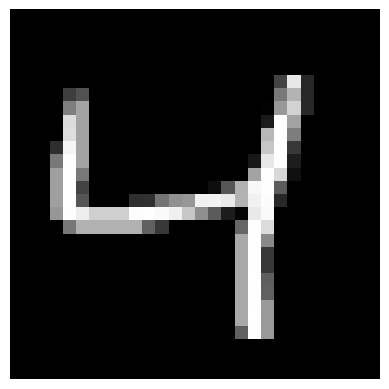

In [5]:
plt.imshow(X_train[2], cmap='gray')
plt.axis('off')
plt.show()

## Implement generator model:

In [6]:
class Generator(keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = Dense(128, activation='relu')
        self.fc2 = Dense(256, activation='relu')
        self.fc3 = Dense(512, activation='relu')
        self.output_layer = Dense(28 * 28 * 1, activation='tanh')

    def call(self, inputs, training=True):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.output_layer(x)
        return x

## Implement discriminator model:

In [7]:
class Discriminator(keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.input_layer = Flatten()
        self.fc1 = Dense(512, activation='leaky_relu')
        self.fc2 = Dense(256, activation='leaky_relu')
        self.fc3 = Dense(128, activation='leaky_relu')
        self.dropout = Dropout(0.3)
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, training=True):
        x = self.input_layer(inputs)
        x = self.fc1(x)
        x = self.dropout(x, training=training)
        x = self.fc2(x)
        x = self.dropout(x, training=training)
        x = self.fc3(x)
        x = self.dropout(x, training=training)
        return self.output_layer(x)

## Implement loss function:

In [26]:
def discriminator_loss(real_output, generated_output):
    return -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1-generated_output))

def generator_loss(generated_output):
    # This is a non-saturating loss. This will ensure the generator will have enough gradient at the beginning of
    # training.
    return -tf.reduce_mean(tf.math.log(generated_output))

In [27]:
def plot_loss(g_losses, d_losses):
    fig = plt.figure(figsize=(8, 8))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Implement optimizer:

In [28]:
generator_optimizer = Adam(learning_rate=0.0001)
discriminator_optimizer = Adam(learning_rate=0.0001)

## Checkpoint:

In [29]:
generator = Generator()
discriminator = Discriminator()

In [30]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator,
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer)

## Traning model:

In [31]:
NOISE_DIM = 100
EPOCHS = 100
num_examples_to_generate = 16
# Create a random vector for testing performance of generator
random_vector_for_generation = tf.random.normal([num_examples_to_generate, NOISE_DIM])

In [32]:
def generate_and_visualize(generator, test_input):
    output_images = generator(test_input, training=False)
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        ax.imshow(tf.reshape(output_images[i], [28, 28]) * 127.5 + 127.5, cmap='gray')
        ax.axis('off')
    plt.show()

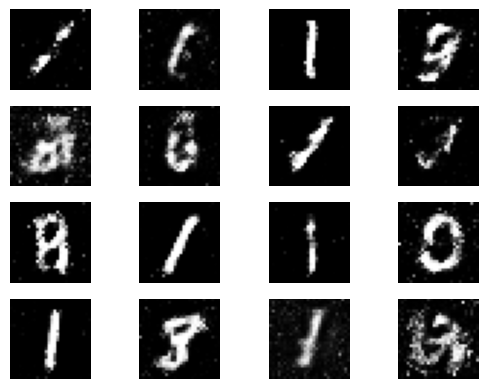

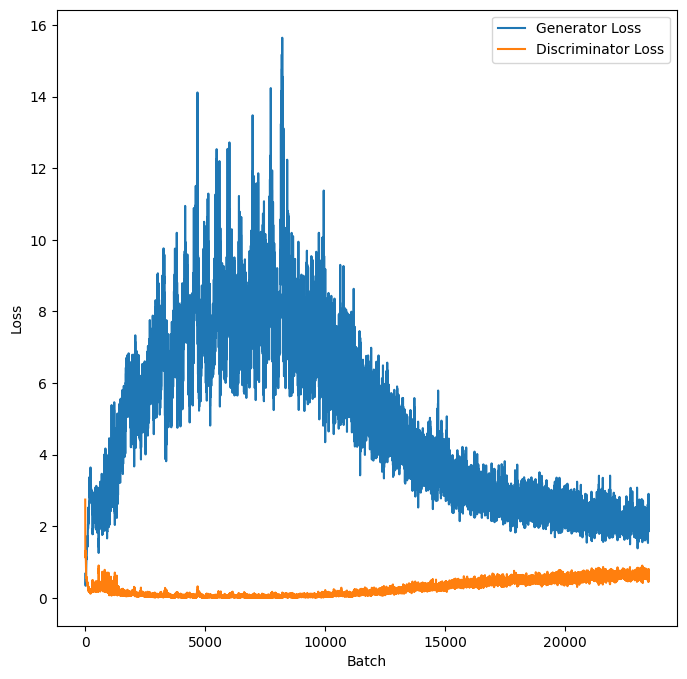

In [33]:
D_losses = []
G_losses = []
def train(dataset, epochs, noise_dims):
    for epoch in range(epochs):
        start = time.perf_counter()
        # In practice 1 epoch update discriminator k times and generator 1 time.
        # But for the simplicity, i will choose k=1.
        for image in dataset:
            noise_vector = tf.random.normal([image.shape[0], noise_dims])
            with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
                generated_image = generator(noise_vector, training=True)
                generated_output = discriminator(generated_image, training=True)
                real_output = discriminator(image, training=True)

                # Calculate loss
                D_loss = discriminator_loss(real_output=real_output, generated_output=generated_output)
                G_loss = generator_loss(generated_output)

            # Calculate gradients
            g_grads = g_tape.gradient(G_loss, generator.variables)
            d_grads = d_tape.gradient(D_loss, discriminator.variables)

            # Update weights
            generator_optimizer.apply_gradients(zip(g_grads, generator.variables))
            discriminator_optimizer.apply_gradients(zip(d_grads, discriminator.variables))

            D_losses.append(D_loss)
            G_losses.append(G_loss)

        # Visualize training procedure
        time_elapsed = time.perf_counter() - start
        display.clear_output(wait=True)
        generate_and_visualize(generator, random_vector_for_generation)
        plot_loss(G_losses, D_losses)
        print(f'Time taken for epoch {epoch} : {time_elapsed}')

        if (epoch + 1) % 20 == 0:
            checkpoint.save(checkpoint_prefix)

    print(f'Done. Final Result :')
    display.clear_output(wait=True)
    generate_and_visualize(generator, random_vector_for_generation)
    plot_loss(G_losses, D_losses)

train(real_dataset, EPOCHS, NOISE_DIM)